# Resolve Flappy Bird using NEAT

#### Loading required libraries

In [1]:
# Tested with python 3.9.6
!pip3 install numpy"==1.26.4" pygame"==2.5.2" setuptools"==69.5.1" tensorflow"==2.16.1" neat-python"==0.92"  graphviz"==0.20.3"
import pygame
import neat
import pickle
from random import randint

Defaulting to user installation because normal site-packages is not writeable
pygame 2.5.2 (SDL 2.28.3, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### Creating Flappy Bird game

In [2]:
class FlappyBirdGame:
    def __init__(self):

        # Game settings
        pygame.init()
        self.game_width = 288
        self.game_height = 512
        self.screen = pygame.display.set_mode((self.game_width, self.game_height))

        # Dimentions
        self.bg_dim = (self.game_width, self.game_height)
        self.floor_dim = (self.game_width, 50)
        self.pipe_dim = (50, 400)
        self.bird_dim = (40, 30)

        # Assets
        self.bg_asset = self.load_assets('assets/background-day.png', self.bg_dim)
        self.floor_asset = self.load_assets('assets/floor.png', self.floor_dim)
        self.bottom_pipe_asset = self.load_assets('assets/pipe-green.png', self.pipe_dim)
        self.top_pipe_asset = pygame.transform.flip(self.bottom_pipe_asset, flip_x = False, flip_y = True)
        self.bird_asset = self.load_assets('assets/bluebird-midflap.png', self.bird_dim)
        self.font = pygame.font.Font('fonts/04B_19.ttf', size = 30)
        
        # Control
        self.floor_speed = -1
        self.initial_speed = -1.4
        self.speed_increase = -0.00002
        self.pipe_distance = 125
        self.bird_gravity = 0.15
        self.bird_jump_factor = -4.5

    def play(self, decision_makers):

        print(f"Game started with {len(decision_makers)} decision makers")

        # Clock
        self.clock = pygame.time.Clock()
        self.speed = self.initial_speed

        # Game objects
        self.background = Background(self)
        self.floor = Floor(self)
        self.score = Score(self)
        self.pipes = [ Pipe(self) ]
        self.birds  = [ Bird(self, decision_maker) for decision_maker in decision_makers ]

        # Game logic
        while not(len(self.birds) == 0 or self.score.score > 150):

            game_objects = [ self.background ] + self.pipes + [ self.floor ] + self.birds + [ self.score ]  

            # Update
            for go in game_objects: go.update()

            # Display
            for go in game_objects: go.draw()
            pygame.display.update()

            # Lifecycle
            for go in game_objects:
                if not go.is_alive(): go.destroy()

            # Next frame
            self.speed += self.speed_increase
            self.clock.tick(120)

        print(f"Game ended")

    def load_assets(self, path, dim):
        assets = pygame.image.load(path).convert()
        return pygame.transform.scale(assets, dim)    
    
    def quit(self):
        pygame.quit()

In [3]:
class GameObject:
    def __init__(self, game: FlappyBirdGame) -> None:
        self.game = game

    def init(self):
        pass

    def draw(self):
        pass

    def update(self):
        pass

    def is_alive(self):
        return True
    
    def destroy(self):
        pass

class Background(GameObject):
    def __init__(self, game: FlappyBirdGame) -> None:
        super().__init__(game)

    def draw(self):
        self.game.screen.blit(self.game.bg_asset, (0, 0))

class Floor(GameObject):
    def __init__(self, game: FlappyBirdGame) -> None:
        super().__init__(game)
        self.floor_rect  = self.game.floor_asset.get_rect(center = (self.game.game_width // 2, self.game.game_height - self.game.floor_dim[1] // 2))
        self.floor_x_offset = 0

    def draw(self):
        self.game.screen.blit(self.game.floor_asset, (self.floor_x_offset, self.game.game_height - self.game.floor_dim[1] // 2))
        self.game.screen.blit(self.game.floor_asset, (self.floor_x_offset - self.game.game_width, self.game.game_height - self.game.floor_dim[1] // 2))

    def update(self):
        self.floor_x_offset = (self.floor_x_offset + self.game.floor_speed) % self.game.game_width

class Score(GameObject):
    def __init__(self, game) -> None:
        super().__init__(game)
        self.game = game
        self.score = 0

    def draw(self):
        score_ui = self.game.font.render(str(int(self.score)), True, (255, 255, 255))
        self.game.screen.blit(score_ui, (self.game.game_width // 2 - 10, 50))

    def update(self):
        self.score += self.game.clock.get_time() / 1000

class Pipe(GameObject):

    def __init__(self, game: FlappyBirdGame) -> None:
        super().__init__(game)
        pipe_height = randint(150, self.game.game_height - self.game.floor_dim[1] - self.game.pipe_distance - 100)
        self.top_pipe_rect = self.game.bottom_pipe_asset.get_rect(bottomleft = (self.game.game_width, pipe_height)) 
        self.bottom_pipe_rect = self.game.top_pipe_asset.get_rect(topleft = (self.game.game_width, pipe_height + self.game.pipe_distance))

    def draw(self):
        self.game.screen.blit(self.game.top_pipe_asset, self.top_pipe_rect)
        self.game.screen.blit(self.game.bottom_pipe_asset, self.bottom_pipe_rect)

    def update(self):
        self.top_pipe_rect.centerx += self.game.speed
        self.bottom_pipe_rect.centerx += self.game.speed
        
    def is_alive(self):
        return self.bottom_pipe_rect.bottomright[0] >= 0
    
    def destroy(self):
        self.game.pipes.remove(self)
        self.game.pipes.append(Pipe(self.game))

class Bird(GameObject):
    
    def __init__(self, game: FlappyBirdGame, decision_maker) -> None:
        super().__init__(game)
        self.bird_rect = self.game.bird_asset.get_rect(center = (self.game.game_width // 5, self.game.game_height // 2 + 50))
        
        self.decision_maker = decision_maker
        self.bird_movement = 0

    def draw(self):
        rotated_asset = pygame.transform.rotozoom(self.game.bird_asset, -self.bird_movement * 2, 1)
        self.game.screen.blit(rotated_asset, self.bird_rect)

    def update(self): 
        
        # Jump
        if self.decision_maker.should_act(self.game, self):
            self.bird_movement = self.game.bird_jump_factor

        # Gravity 
        self.bird_movement += self.game.bird_gravity
        self.bird_rect.centery += self.bird_movement

        # Update reward
        self.decision_maker.reward(self.game.score.score)

    def is_alive(self):

        # Check if is out of the map
        if (self.bird_rect.midtop[1] < 0):
            # print("Bird went out of map")
            return False

        # Check if collided with map
        if (self.bird_rect.colliderect(self.game.floor.floor_rect)):
            # print("Detected collision with floor")
            return False

        # Check if collided with any pipe
        for pipe in self.game.pipes: 
            if self.bird_rect.colliderect(pipe.top_pipe_rect):
                # print("Detected collision with top pipe")
                return False
            
            if self.bird_rect.colliderect(pipe.bottom_pipe_rect):
                # print("Detected collision with bottom pipe")
                return False
            
        return True    
    
    def destroy(self):
        self.game.birds.remove(self)

In [4]:
class DecisionMaker:
    def should_act(self, game: FlappyBirdGame, bird: Bird) -> bool:
        pass

    def reward(self, reward) -> None:
        pass

class PlayerDecisionMaker(DecisionMaker):
    def __init__(self) -> None:
        pass

    def should_act(self, game: FlappyBirdGame, bird: Bird) -> bool:

        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                return True
        
        return False

class AiDecisionMaker(DecisionMaker):
    def __init__(self, genome, config) -> None:
        self.genome = genome
        self.genome.fitness = 0
        self.net = neat.nn.FeedForwardNetwork.create(genome, config)

    def should_act(self, game: FlappyBirdGame, bird: Bird) -> bool:

        pipes_nb = len(game.pipes)

        state = (
            bird.bird_rect.bottomleft[0],
            bird.bird_rect.bottomleft[1],
            bird.bird_rect.size[0],
            bird.bird_rect.size[1],
            game.pipes[0].top_pipe_rect.bottomleft[0] if pipes_nb >= 1 else -1,
            game.pipes[0].top_pipe_rect.bottomleft[1] if pipes_nb >= 1 else -1,
            game.pipes[0].bottom_pipe_rect.topright[0] if pipes_nb >= 1 else -1,
            game.pipes[0].bottom_pipe_rect.topright[1] if pipes_nb >= 1 else -1,
        )

        threshold = self.net.activate(state)[0]

        return threshold >= 0.5
    
    def reward(self, reward) -> None:
        self.genome.fitness = reward

In [5]:
class PlayerFlappyBirdGame:
    def __init__(self) -> None:
        self.game = FlappyBirdGame() 
        
    def play(self):
        self.game.play([ PlayerDecisionMaker() ])
        
    def quit(self):
        self.game.quit()


class AiFlappyBirdGame:
    def __init__(self) -> None:
        self.game = FlappyBirdGame() 
        
    def play(self, genomes, config):
        self.game.play([ AiDecisionMaker(genome, config) for _, genome in genomes ])
        
    def quit(self):
        self.game.quit()

In [6]:
# playable_game = PlayerFlappyBirdGame()
# playable_game.play()
# playable_game.quit()

#### Visualization

In [7]:
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

#### Training an AI with NEAT

In [8]:
def load_config():
    # Load configuration
    return neat.Config(
        neat.DefaultGenome, 
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet, 
        neat.DefaultStagnation,
        'config-feedforward'
    )

In [9]:
def load_population(config, checkpoint = None):
    
    if checkpoint:
        print("Resuming from checkpoint: {}".format(checkpoint))
        
        # Load population from latest checkpoint
        return neat.Checkpointer.restore_checkpoint(checkpoint)
    
    else:
        print("Starting run from scratch")

        # Create the population, which is the top-level object for a NEAT run
        return neat.Population(config)
        

In [10]:
def save_genome(genome, path):
    # Unpickle saved winner
    with open(path, "wb") as f:
        pickle.dump(genome, f)

In [11]:
def load_genome(path):
    # Unpickle saved winner
    with open(path, "rb") as f:
        return pickle.load(f)

Starting run from scratch

 ****** Running generation 0 ****** 

Game started with 75 decision makers
Game ended
Population's average fitness: 0.64583 stdev: 0.87254
Best fitness: 7.74000 - size: (1, 8) - species 1 - id 39
Average adjusted fitness: 0.041
Mean genetic distance 1.226, standard deviation 0.489
Population of 75 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    75      7.7    0.041     0
Total extinctions: 0
Generation time: 7.771 sec
Saving checkpoint to results/net_0

 ****** Running generation 1 ****** 

Game started with 75 decision makers
Game ended
Population's average fitness: 0.67005 stdev: 0.41778
Best fitness: 2.14300 - size: (1, 8) - species 1 - id 39
Average adjusted fitness: 0.181
Mean genetic distance 1.416, standard deviation 0.517
Population of 75 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    75      2.1    0.181  

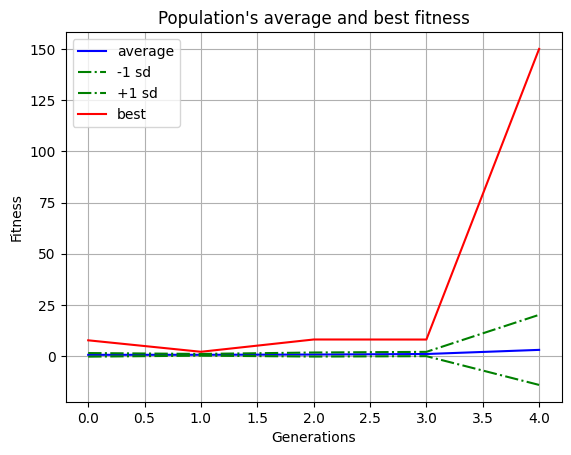

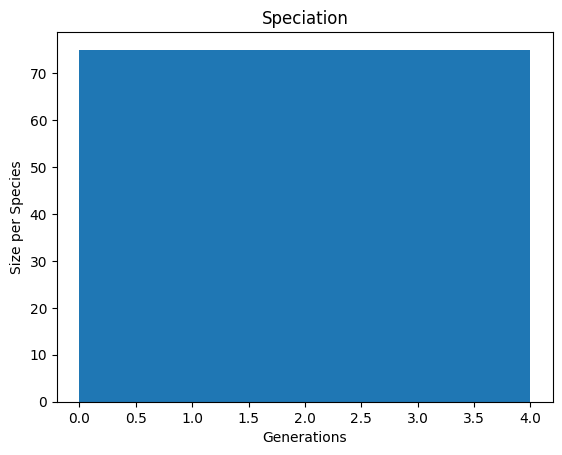

In [12]:
def train(checkpoint, generations_nb):

    # Load config
    config = load_config()

    # Load a previously created population or a new one
    population = load_population(config, checkpoint)

    # Add a reporters to show progress 
    population.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    population.add_reporter(stats)
    population.add_reporter(neat.Checkpointer(generation_interval = 1, filename_prefix="results/net_"))

    # Run for up to n generations
    game = AiFlappyBirdGame()
    winner = population.run(game.play, generations_nb)    

    if winner:
        # Save & draw results
        print('\nBest genome:\n{!s}'.format(winner))
        save_genome(winner, "results/winner_neat.neat")
        draw_net(config, winner, view=False, node_names=None, filename="results/winner_net")
        plot_stats(stats, ylog=False, view=True, filename="results/fitness.svg") 
        plot_species(stats, view=True, filename="results/speciation.svg")

    return winner

best_genome = train(checkpoint = None, generations_nb = None)

#### Play with our trained AI

In [13]:
# config = load_config()
# best_genome = load_genome("results/winner_neat.neat")

In [14]:
# ai_game = AiFlappyBirdGame()
# ai_game.play([ (1, best_genome) ], config)
# ai_game.quit()

In [15]:
pygame.quit()

: 